COMP5930M Scientific Computation - Tutorial 5  \\
Example of a 1-D PDE, the Fisher equation

The Fisher equation is: find $u(x,t)$ in $(a,b) \times (0,T)$ s.t.

$$
\frac{\partial u}{\partial t} = u \frac{\partial u}{\partial  x} + u (1-u)
$$
where the initial value $u(x,0) = u_0(x)$ and the boundary conditions $u(a,t) = \alpha$ and $u(b,t) = \beta$ are specified to fix a unique solution to the PDE.

We will need our previous implementation of Newton's method for systems:

In [ ]:
import numpy as np
from numpy.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    n = F.size

    print(' k    f(xk)')

    # Main Newton loop
    while (norm(F,2) > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        delta = np.linalg.solve(J,-F)
        x = x + delta

        F = eval(fnon)(x,*fnonargs)

        print('{0:2.0f}  {1:2.2e}'.format(k, norm(F,2)))
        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x

Since the Fischer equation is a time-dependent initial-value problem, we need to define the initial value of the function $u(x,0) = u_0(x)$.

In [ ]:
import numpy as np

def initialData( m ):

  # Initial solution profile
  # Input: grid size m
  # Output: initial condition u

  # spatial domain endpoints
  xL = 0
  xR = 1

  h = (xR - xL) / (m-1)                      # mesh size
  x = np.linspace(xL, xR, m).reshape((m, 1)) # grid points

  v = 0.4 + 0.2 * np.exp(-40 * (x - 0.5)**2) # initial data

  uL = v[0]   # boundary conditions
  uR = v[m-1]

  return v

The main part of the implementation is the discrete system of equations $F(u^{k},u^{k-1}) =0$:

$$
\frac{u_i^{k}-u_i^{k-1}}{\Delta t} - u_i^k \left( \frac{u_{i+1}^{k} -2 u_i^{k}+u_{i-1}^{k}}{h^2} \right) - u_i^{k}(1-u_i^{k}) = 0.
$$

These equations need to be solved for each $u^k$ given the solution vector at the previous time step $u^{k-1}$ (uOld).

Boundary conditions are explicited at the nodes $x_1$ and $x_m$ so we only need to solve the equations for $i=2,3,\ldots,m-1$.

In [ ]:
def fisherFDM( u, uOld, dt, h ):

  # Nonlinear residual function
  # Input: u    - current solution values (dimension (m-2) x 1)
  #        uOld - previous solution (dimension m x 1)
  #        dt   - time-step
  #        h    - spatial grid size
  # Output: f   - nonlinear functions evaluated at u

  m = uOld.size
  f = np.zeros( (m-2, 1) )

  # Take the boundary conditions from the previous solution
  uL = uOld[0]
  uR = uOld[m-1]

  # Difference equation at the left boundary
  f[0] = ( u[0] - uOld[0] ) / dt - u[0] * ( u[1] - 2*u[0] + uL ) / h**2 - u[0] * ( 1 - u[0] )

  # Difference equations at each internal node
  for i in range(1,m-3):
    f[i] = ( u[i] - uOld[i] ) / dt - u[i] * ( u[i+1] - 2*u[i] + u[i-1] ) / h**2 - u[i] * ( 1 - u[i] )

  # Difference equation at the right boundary
  f[m-3] = ( u[m-3] - uOld[m-3] ) / dt - u[m-3] * ( uR - 2*u[m-3] + u[m-4] ) / h**2 - u[m-3] * ( 1 - u[m-3] )

  return f

To simplify the Newton implementation, we will use the finite-difference Jacobian algorithm:

In [ ]:
import numpy as np
import copy

def fdJacobian(x,n,fnon,F0,*fnonargs):
  J = np.zeros((n,n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.copy(x)
    xb[k] = xb[k] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
        J[i,k] = (F[i] - F0[i]) / h

  return J

Now we have everything we need to introduce the main time-stepping loop:

In [ ]:
def fisherModel( dtIn, nTimeSteps, mIn ):

  # Implicit Euler in time, finite difference in space
  # numerical model for the Fisher Equation
  #  function sols = fisherModel( dtIn, nTimeSteps, mIn )
  # Input:  dtIn       - time step size
  #         nTimeSteps - number of time steps
  #         mIn        - grid dimension
  # Output: sols       - array of solution vectors u^k

  dt = dtIn   # time step size
  m = mIn     # dimension of spatial mesh for [X1,X2]
  n = m-2     # number of nonlinear equations (excluding boundary condition)
  h = 1/(m-1) # grid size

  # Initial and boundary conditions
  uOld = initialData( m )
  u0 = np.zeros( (n,1) )

  # Create an array for the solutions in time
  sols = []
  sols.append(uOld)

  # Time stepping loop
  for k in range( 0, nTimeSteps ):
    print('Time step: {0:1.0f}'.format(k))

    # Use previous time step as the Newton initial guess
    u0 = uOld[1:n+1]

    # Call the Newton solver
    u = myNewtonSys("fisherFDM", "fdJacobian", u0, 1e-6, 10, uOld, dt, h)

    # Update the previous time step
    uOld[1:n+1] = u[0:n]

    # Store the solution vector
    sols.append(copy.copy(uOld))

  return sols;

In [ ]:
sols = fisherModel( 0.001, 100, 20 )

Time step: 0
 k    f(xk)
 0  1.49e-02
 1  3.26e-08
Time step: 1
 k    f(xk)
 0  1.12e-02
 1  1.79e-08
Time step: 2
 k    f(xk)
 0  8.54e-03
 1  1.02e-08
Time step: 3
 k    f(xk)
 0  6.66e-03
 1  6.05e-09
Time step: 4
 k    f(xk)
 0  5.29e-03
 1  3.72e-09
Time step: 5
 k    f(xk)
 0  4.25e-03
 1  2.36e-09
Time step: 6
 k    f(xk)
 0  3.46e-03
 1  1.55e-09
Time step: 7
 k    f(xk)
 0  2.85e-03
 1  1.04e-09
Time step: 8
 k    f(xk)
 0  2.37e-03
 1  7.18e-10
Time step: 9
 k    f(xk)
 0  1.99e-03
 1  5.09e-10
Time step: 10
 k    f(xk)
 0  1.69e-03
 1  3.69e-10
Time step: 11
 k    f(xk)
 0  1.44e-03
 1  2.74e-10
Time step: 12
 k    f(xk)
 0  1.23e-03
 1  2.07e-10
Time step: 13
 k    f(xk)
 0  1.06e-03
 1  1.60e-10
Time step: 14
 k    f(xk)
 0  9.23e-04
 1  1.26e-10
Time step: 15
 k    f(xk)
 0  8.05e-04
 1  1.01e-10
Time step: 16
 k    f(xk)
 0  7.06e-04
 1  8.16e-11
Time step: 17
 k    f(xk)
 0  6.21e-04
 1  6.73e-11
Time step: 18
 k    f(xk)
 0  5.49e-04
 1  5.61e-11
Time step: 19
 k    f(

We can visualise the solutions in one plot...

Text(0, 0.5, 'u(x,t)')

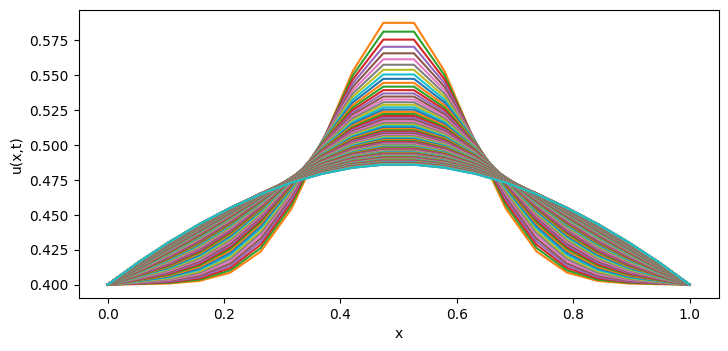

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
x=np.linspace(0, 1, 20)

fig=plt.figure()
ax=fig.add_axes([0,0.4,1,0.6])
for t in range(0,100):
  ax.plot(x,sols[t])
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

...or as an animation over time:

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,6));
ax = plt.axes( );
plt.close();

In [ ]:
def frame(w):
    ax.clear()
    global x,y,z
    x=np.linspace(0, 1, 20)
    ax.set_xlabel('x')
    ax.set_xlim(0,1)
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0.4,0.6)
    plot = ax.plot(x, sols[w])


In [ ]:
anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

In [ ]:
anim